In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import pandas as pd

In [3]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from wfdb import processing
import numpy as np

In [4]:
data = pd.read_csv("X_train.csv")

In [5]:
answers = pd.read_csv("y_train.csv")

In [6]:
data = (pd.merge(data ,answers, on = "Unnamed: 0"))
data['age'] = (data['age'] - data['age'].mean(axis = 0))/data['age'].std(axis = 0)

In [7]:
data = data.drop( ["Unnamed: 0"], axis = 1)

In [8]:
data.head()

,age,gender,i_0,i_1,i_2,i_3,i_4,i_5,i_6,i_7,...,v6_4991,v6_4992,v6_4993,v6_4994,v6_4995,v6_4996,v6_4997,v6_4998,v6_4999,axis_id
0,0.192357,1,-59.0,-58.0,-58.0,-58.0,-58.0,-58.0,-58.0,-58.0,...,114.0,119.0,124.0,129.0,134.0,147.0,172.0,200.0,143.0,3
1,1.399105,0,-39.0,-38.0,-38.0,-38.0,-38.0,-38.0,-38.0,-38.0,...,229.0,259.0,289.0,319.0,349.0,379.0,409.0,439.0,302.0,3
2,0.137505,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-58.0,-58.0,-58.0,-58.0,-58.0,-58.0,-38.0,-11.0,-2.0,2
3,1.344253,0,108.0,106.0,93.0,79.0,86.0,74.0,64.0,51.0,...,81.0,89.0,79.0,59.0,61.0,64.0,49.0,26.0,10.0,3
4,-1.453208,1,363.0,366.0,366.0,353.0,334.0,314.0,306.0,294.0,...,-61.0,-59.0,-86.0,-66.0,-71.0,-91.0,-84.0,-11.0,-4.0,0


In [10]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [11]:
from filters import bandpass_filter

In [12]:
class ECGDataset(Dataset):
    def __init__(self, data, signal_length):
        super().__init__()
        self.data = data.values
        self._process_dataset()
        self.signal_length = signal_length
        used_data = self.signals
        used_data = [np.array(row) for row in used_data.copy()]
        used_data = np.array(used_data)
        self.mean = used_data.mean()
        self.std = used_data.std()
        self.values = (used_data - used_data.mean())/used_data.std()

    def __len__(self):
        return len(self.values)

    def _get_row(self, row):
        return [bandpass_filter(row[i : i + 5000], {}) for i in range(2, 55003, 5000)]
        
    def _process_dataset(self):
        self.signals = np.apply_along_axis(lambda x: self._get_row(x), 1, self.data)

        
    def __getitem__(self, idx):
        """
        Generates one sample of data.
        """
        cut_point = 0 if self.signal_length >= 5000 else np.random.randint(5001 - self.signal_length)
        signals = self.values[idx][:, cut_point:cut_point+self.signal_length]
        
        return signals, self.data[idx][-1]

In [13]:
class TestECGDataset(Dataset):
    def __init__(self, data, signal_length, train_mean, train_std):
        super().__init__()
        self.data = data.values
        self._process_dataset()
        self.signal_length = signal_length
        used_data = self.signals
        used_data = [np.array(row) for row in used_data.copy()]
        used_data = np.array(used_data)
        self.values = (used_data - train_mean)/train_std


    def __len__(self):
        return len(self.values)

        
    def _get_row(self, row):
        return [bandpass_filter(row[i : i + 5000], {}) for i in range(2, 55003, 5000)]
        
    def _process_dataset(self):
        self.signals = np.apply_along_axis(lambda x: self._get_row(x), 1, self.data)

        
    def __getitem__(self, idx):
        """
        Generates one sample of data.
        """
        cut_point = 0 if self.signal_length >= 5000 else np.random.randint(5001 - self.signal_length)
        signals = self.values[idx][:, cut_point:cut_point+self.signal_length]
        
        return signals, self.data[idx][-1]

In [14]:
valid_size = 0.1

num_train = len(data)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

np.random.seed(7)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_dataset = ECGDataset(data.iloc[train_idx], 3000)
valid_dataset = TestECGDataset(data.iloc[valid_idx], 3000, train_dataset.mean, train_dataset.std)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [15]:
batchsize = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batchsize, shuffle = True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batchsize, shuffle = False
)

In [16]:
import torch.nn as nn

In [18]:
class CNN1d(nn.Module):
    def __init__(self, dropout=0.3):
        super(CNN1d, self).__init__()
        #[batch size, channels_12, 3000]
        
        self.layer1 = nn.Sequential(
            nn.Conv1d(12, 128, kernel_size=3, padding = 1), 
            nn.BatchNorm1d(128),
            nn.ReLU(), 
            nn.Conv1d(128, 128, kernel_size=3, padding = 1), 
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=3, padding = 1), 
            nn.BatchNorm1d(128),
            nn.Dropout(dropout)
        ) 
        
        self.shortcut1 =  nn.Sequential(
            nn.Conv1d(12, 128, kernel_size=1),
            nn.BatchNorm1d(128)
        )
        self.sum_relu1 = nn.ReLU()
        
        self.layer2 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, padding = 1), 
            nn.BatchNorm1d(256),
            nn.ReLU(), 
            nn.Conv1d(256, 256, kernel_size=3, padding = 1), 
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=3, padding = 1), 
            nn.BatchNorm1d(256),
            nn.Dropout(dropout)
        ) 
        
        self.shortcut2 =  nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=1),
            nn.BatchNorm1d(256)
        )
        
        self.sum_relu2 = nn.ReLU()
        
        self.layer3 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, padding = 1), 
            nn.BatchNorm1d(256),
            nn.ReLU(), 
            nn.Conv1d(256, 256, kernel_size=3, padding = 1), 
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=3, padding = 1), 
            nn.BatchNorm1d(256),
            nn.Dropout(dropout)
        ) 
        
        self.shortcut3 =  nn.Sequential(
            nn.BatchNorm1d(256)
        )
        self.sum_relu3 = nn.ReLU()
        
        self.time_avg = nn.AvgPool1d(3000)
       
        self.fc = nn.Linear(256, 4)
        self.sm = nn.Softmax(dim = 1)
        
    def forward(self, x):
        identity = x
        
        out = self.layer1(identity)
        short = self.shortcut1(identity)
        out += short
        identity = self.sum_relu1(out)
        
        
        out = self.layer2(identity)
        short = self.shortcut2(identity)
        out += short
        identity = self.sum_relu2(out)
        
        out = self.layer3(identity)
        short = self.shortcut3(identity)
        out += short
        identity = self.sum_relu3(out)
        
        out = self.time_avg(identity)
        out = out.squeeze(2)
        
        out = self.fc(out)
        out = self.sm(out)
        return out

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [23]:
model = CNN1d().to(device)

In [24]:
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [25]:
weigths = torch.tensor([sum(data.axis_id==2)/sum(data.axis_id==0),sum(data.axis_id==2)/sum(data.axis_id==1),sum(data.axis_id==2)/sum(data.axis_id==2),sum(data.axis_id==2)/sum(data.axis_id==3)]).to(device)

In [26]:
optimizer = optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss(weigths)

In [27]:
def validate(model, loader):
    model.eval()
    val_length = 0
    correct_answers = 0
    for i, (ecg, label_idx) in enumerate(loader):

        src = ecg.to(device).float()
        trg = label_idx.to(device).long()

        output = model(src)
        
        answer = output.argmax(dim = 1).long()
        res = answer == trg 
        
        val_length += len(answer)
        correct_answers += res.sum().float()
    return correct_answers/val_length
        

In [28]:
validate(model, valid_loader)

tensor(0.1692, device='cuda:0')

In [29]:
def train(model, n_epoch, optimizer, criterion, print_every = 100, valid_every=10):
    model.train()
    total_step = len(train_loader)
    history = []
    for epoch in range(n_epoch):
        epoch_loss = 0
        

        for i, (ecg, label_idx) in enumerate(train_loader):
            
            src = ecg.to(device).float()
            trg = label_idx.to(device).long()

            optimizer.zero_grad()

            output = model(src)

            loss = criterion(output, trg )
            if (torch.isnan(loss).item()  == 1):
                print("NAN loss")
                print(src)
                print(trg)
                return

            loss.backward()
            optimizer.step()
            
            if ((epoch+1) % valid_every == 0) and ((i+1) % print_every == 0):
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, n_epoch, i+1, total_step, loss.item()))
        
        if ((epoch+1) % valid_every == 0):
            train_accuracy = validate(model, train_loader).item()
            valid_accuracy = validate(model, valid_loader).item()
            history.append([train_accuracy, valid_accuracy])
            print ('Epoch [{}/{}], Accuracy: {:.4f} / {:.4f}' 
                   .format(epoch+1, n_epoch, train_accuracy, valid_accuracy))
            print()
            model.train()
    return history
        
                

In [30]:
history = train(model, 1000, optimizer, criterion, 9, 10)

Epoch [10/1000], Step [9/19], Loss: 0.9300
Epoch [10/1000], Step [18/19], Loss: 1.0563
Epoch [10/1000], Accuracy: 0.6330 / 0.6154

Epoch [20/1000], Step [9/19], Loss: 0.9131
Epoch [20/1000], Step [18/19], Loss: 1.0690
Epoch [20/1000], Accuracy: 0.7290 / 0.6000

Epoch [30/1000], Step [9/19], Loss: 0.8933
Epoch [30/1000], Step [18/19], Loss: 1.0009
Epoch [30/1000], Accuracy: 0.7576 / 0.7077

Epoch [40/1000], Step [9/19], Loss: 0.9712
Epoch [40/1000], Step [18/19], Loss: 1.0373
Epoch [40/1000], Accuracy: 0.6768 / 0.6154

Epoch [50/1000], Step [9/19], Loss: 0.8649
Epoch [50/1000], Step [18/19], Loss: 0.9692
Epoch [50/1000], Accuracy: 0.7997 / 0.7077

Epoch [60/1000], Step [9/19], Loss: 0.9384
Epoch [60/1000], Step [18/19], Loss: 0.9188
Epoch [60/1000], Accuracy: 0.7862 / 0.6769

Epoch [70/1000], Step [9/19], Loss: 0.8938
Epoch [70/1000], Step [18/19], Loss: 0.8748
Epoch [70/1000], Accuracy: 0.7458 / 0.6615

Epoch [80/1000], Step [9/19], Loss: 0.9267
Epoch [80/1000], Step [18/19], Loss: 0.9

In [31]:
import gc
gc.collect()

7

In [32]:
torch.cuda.empty_cache()

In [33]:
validate(model, valid_loader).item()

0.6769230961799622

In [34]:
import seaborn as sn

In [35]:
def get_preds_and_true(model, loader, dataset):
    y_pred = np.zeros((len(dataset),))
    y_true = np.zeros((len(dataset),))
    offset = 0
    for i, (ecg,  label_idx) in enumerate(loader):

        src = ecg.to(device).float()
        trg = label_idx.to(device).long()

        output = model(src)
        
        answer = output.argmax(dim = 1).long()
        l = len(answer)

        y_pred[offset:offset+l] = answer.cpu().numpy()
        y_true[offset:offset+l] = trg.cpu().numpy()

        offset = offset + l
        
    return y_pred, y_true

In [36]:
batchsize = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batchsize, shuffle = True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batchsize, shuffle = False
)

In [37]:
get_preds_and_true(model, valid_loader, valid_dataset)

(array([2., 2., 3., 3., 0., 3., 2., 3., 3., 2., 0., 2., 2., 0., 3., 3., 3.,
        0., 0., 3., 1., 2., 3., 2., 2., 3., 0., 3., 3., 3., 2., 3., 3., 3.,
        2., 0., 3., 1., 1., 3., 1., 1., 2., 2., 3., 1., 3., 2., 2., 1., 3.,
        1., 3., 2., 0., 3., 3., 3., 1., 2., 3., 0., 1., 2., 1.]),
 array([2., 2., 3., 3., 0., 3., 1., 3., 3., 2., 2., 2., 0., 0., 3., 3., 3.,
        0., 2., 3., 2., 2., 3., 3., 3., 3., 2., 3., 3., 3., 2., 3., 1., 3.,
        3., 2., 0., 3., 1., 3., 2., 1., 1., 1., 1., 1., 3., 2., 2., 1., 3.,
        2., 3., 2., 0., 1., 3., 3., 2., 2., 3., 1., 2., 2., 3.]))

In [38]:
import gc

In [39]:
gc.collect()

0

In [40]:
torch.cuda.empty_cache()

In [41]:
from sklearn.metrics import confusion_matrix

In [42]:
def plot_confusion_matrix( y_test_predict, y_test):
    sn.heatmap(confusion_matrix(y_test, y_test_predict), annot=True)
   

In [325]:
y_pred, y_true = get_preds_and_true(model, valid_loader, valid_dataset)
np.sum(y_pred==y_true)/len(y_pred)

0.6923076923076923

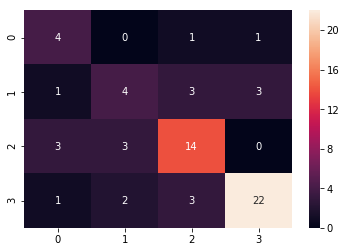

In [279]:
plot_confusion_matrix(y_pred, y_true)

In [280]:
np.array(range(len(valid_dataset)))[np.logical_and((y_true == 1),(y_pred==2))]

array([ 6, 42, 43])

In [281]:
valid_dataset[38][0].transpose().shape

(3000, 12)

In [282]:
leds = ['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', 'v2', 'v3', 'v4', 'v5',
       'v6']

In [283]:
valid_dataset.data.shape

(65, 60003)

In [284]:
from sklearn import metrics

In [285]:
metrics.accuracy_score(y_true, y_pred)

0.676923076923077

In [286]:
metrics.recall_score(y_true, y_pred, average=None)

array([0.66666667, 0.36363636, 0.7       , 0.78571429])

In [287]:
metrics.precision_score(y_true, y_pred, average=None)

array([0.44444444, 0.44444444, 0.66666667, 0.84615385])

In [288]:
metrics.f1_score(y_true, y_pred, average=None)

array([0.53333333, 0.4       , 0.68292683, 0.81481481])

In [289]:
metrics.recall_score(y_true, y_pred, average='weighted')

0.676923076923077

In [57]:
history_arr = np.array(history)

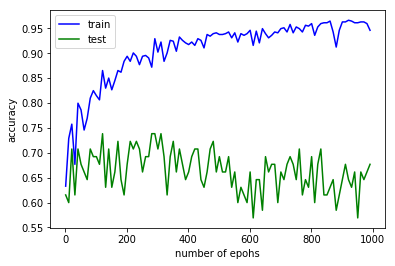

In [58]:
plt.plot(range(1, 1001, 10), history_arr[:, 0], 'b')
plt.plot(range(1, 1001, 10), history_arr[:, 1], 'g')
plt.xlabel('number of epohs')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])
plt.show()